In [1]:
import wrf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import xarray as xr
import netCDF4 as nc
import numpy as np
import math
import cartopy.crs as ccrs

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

In [2]:
def uv(df):
    
        df["u"] = [-ws * math.sin(math.radians(wd)) for ws, wd in zip(df["ws"].values, df["wd"].values)]
        df["v"] = [-ws * math.cos(math.radians(wd)) for ws, wd in zip(df["ws"].values, df["wd"].values)]        
        
        return df

def load_obs(time):
    
    #Load upper air sounding for sydney airport
    
    names = ["record_id","stn_id","date_time","ta","ta_quality","dp","dp_quality",\
            "rh","rh_quality","ws","ws_quality","wd","wd_quality","p","p_quality",
            "z","z_quality","symbol"]

    ua = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/upper_air/UA01D_Data_066037_999999999723955.txt",header=None,names=names)
    ua["date_time"] = pd.to_datetime(ua["date_time"],format="%d/%m/%Y %H:%M")
    ua = ua.set_index("date_time").loc[time]
    
    for c in ["ta","dp","rh","ws","wd","p","z"]:
        ua[c] = pd.to_numeric(ua[c],errors="coerce")
    
    return uv(ua).dropna()

#Load radiosonde from disk
obs = load_obs("2016-1-14 02:00")

#Save .csv
obs.to_csv("/home/548/ab4502/working/wrf_output_analysis/20160114_obs.csv")

#Extract obs data into arrays and assign units
p_obs_arr = obs["p"].values * units.hectopascal
tc_obs_arr = obs["ta"].values * units.degree_Celsius
td_obs_arr = obs["dp"].values * units.degree_Celsius
hgt_obs_arr = obs["z"].values * units.meter
u_obs_arr = obs["u"].values * units.meter_per_second
v_obs_arr = obs["v"].values * units.meter_per_second

#Get log spacing for p, u and v
xp = np.flip(obs["p"]).values
yp = np.flip(np.arange(obs.shape[0]))
xi = np.logspace(3,2,20)
pind = np.interp(xi,xp,yp).round().astype(int) 
p_obs_logarr = obs["p"].iloc[pind].values * units.hectopascal
u_obs_logarr = obs["u"].iloc[pind].values * units.meter_per_second
v_obs_logarr = obs["v"].iloc[pind].values * units.meter_per_second

In [3]:
def extract_wrf_all(tc, hgt, p, td, u, v, lat=-33.9500, lon=151.1817):
    
    x_y = wrf.ll_to_xy(wrfout,lat,lon)
    x = int(x_y.sel(x_y="x").values)
    y = int(x_y.sel(x_y="y").values)    
    
    #Take wrf grids and output arrays with units
    p_out = p.sel(west_east=x,south_north=y).values/100 * units.hectopascal
    tc_out = tc.sel(west_east=x,south_north=y).values * units.degree_Celsius
    td_out = td.sel(west_east=x,south_north=y).values * units.degree_Celsius    
    hgt_out = hgt.sel(west_east=x,south_north=y).values * units.meter
    u_out = u.sel(west_east=x,south_north=y).values * units.meter_per_second
    v_out = v.sel(west_east=x,south_north=y).values * units.meter_per_second
    
    return p_out, tc_out, td_out, hgt_out, u_out, v_out, p.sel(west_east=x,south_north=y)["XLONG"].values, p.sel(west_east=x,south_north=y)["XLAT"].values

def extract_wrf_logspace(tc, hgt, p, td, u, v, lat=-33.9500, lon=151.1817):
    
    x_y = wrf.ll_to_xy(wrfout,lat,lon)
    x = int(x_y.sel(x_y="x").values)
    y = int(x_y.sel(x_y="y").values)    
    
    xp = np.flip(p.sel(west_east=x,south_north=y).values)
    yp = np.flip(p.bottom_top.values)
    xi = np.logspace(3,2,20) * 100

    pind = np.interp(xi,xp,yp).round().astype(int)    
    
    #Take wrf grids and output arrays with units, but with log spacing in vertical (for nice wind barb spacing)
    p_out = p.sel(west_east=x,south_north=y,bottom_top=pind).values/100 * units.hectopascal
    tc_out = tc.sel(west_east=x,south_north=y,bottom_top=pind).values * units.degree_Celsius
    td_out = td.sel(west_east=x,south_north=y,bottom_top=pind).values * units.degree_Celsius    
    hgt_out = hgt.sel(west_east=x,south_north=y,bottom_top=pind).values * units.meter
    u_out = u.sel(west_east=x,south_north=y,bottom_top=pind).values * units.meter_per_second
    v_out = v.sel(west_east=x,south_north=y,bottom_top=pind).values * units.meter_per_second
    
    return p_out, tc_out, td_out, hgt_out, u_out, v_out

#Load the WRF netcdf output from disk
wrfout = nc.Dataset("/g/data/eg3/ab4502/WRF_simulations/mr1883/5km/wrfout_d01_2016-01-14_02:00:00")

#Extract relevant variables using wrf-python
tc_wrf = wrf.getvar(wrfout,"tc")   #Celcius
hgt_wrf = wrf.getvar(wrfout,"z")   #m
p_wrf = wrf.getvar(wrfout,"p")     #Pa
td_wrf = wrf.getvar(wrfout,"td")   #Celcius
u_wrf = wrf.getvar(wrfout,"ua")    #m/s
v_wrf = wrf.getvar(wrfout,"va")    #m/s

#Extract profiles nearest to Sydney airport
p_wrf_arr, tc_wrf_arr, td_wrf_arr, hgt_wrf_arr, u_wrf_arr, v_wrf_arr, wrf_lon, wrf_lat = extract_wrf_all(tc_wrf, hgt_wrf, p_wrf, td_wrf, u_wrf, v_wrf)
#Extract profiles but decrease spacing to log-p for nice wind barb spacing
p_wrf_logarr, tc_wrf_logarr, td_wrf_logarr, hgt_wrf_logarr, u_wrf_logarr, v_wrf_logarr = extract_wrf_logspace(tc_wrf, hgt_wrf, p_wrf, td_wrf, u_wrf, v_wrf)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/numpy/lib/function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


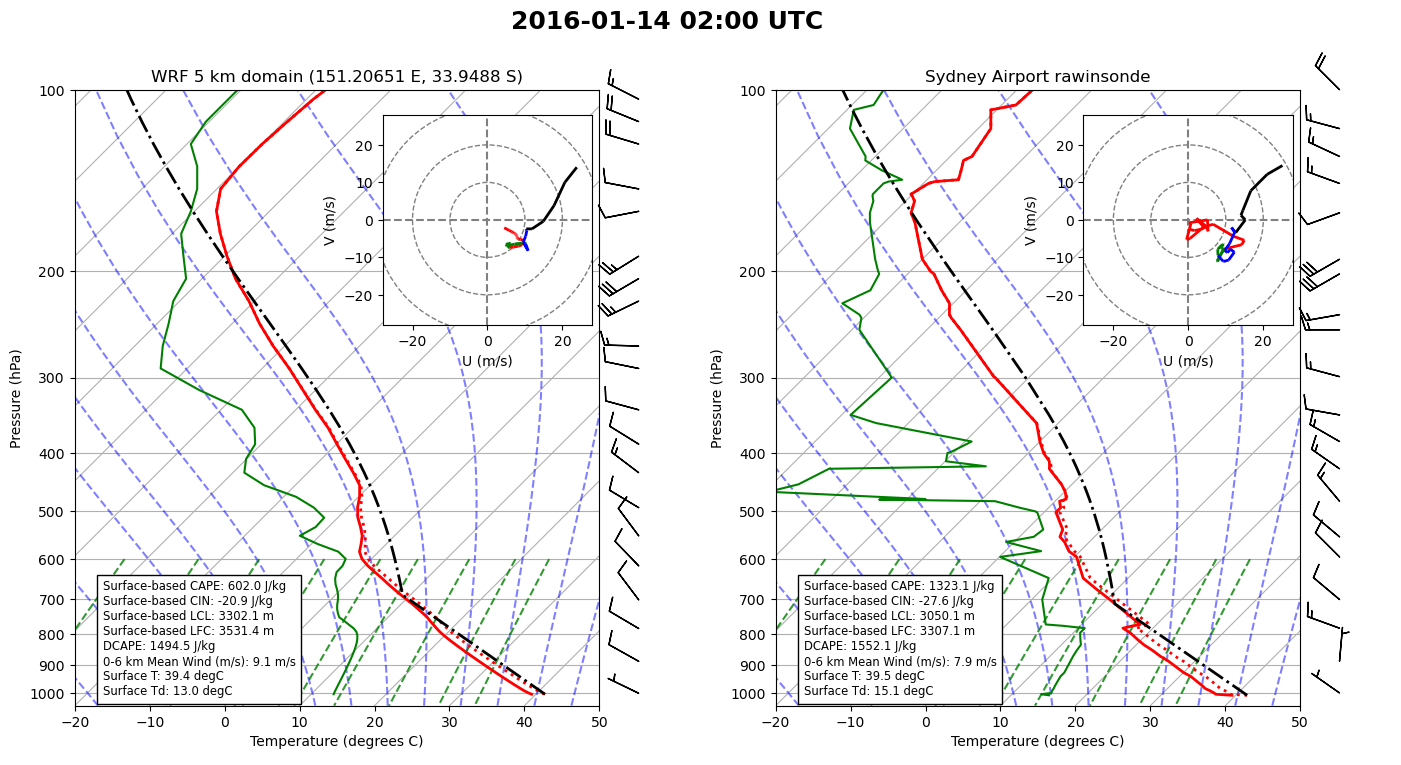

In [4]:
def get_pcl(pres, hght, tmpc, dwpc, u, v, flag):
    
    prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, u=u*1.94384, v=v*1.94384, missing=-9999, strictQC=False)
    
    return params.parcelx( prof, flag=flag )
    
def calc_params(pres, hght, tmpc, dwpc, u, v):
    
    prof = profile.create_profile(profile='default', pres=pres, hght=hght, tmpc=tmpc, \
                                    dwpc=dwpc, u=u*1.94384, v=v*1.94384, missing=-9999, strictQC=False)
    
    sfcpcl = params.parcelx( prof, flag=1 ) # Surface Parcel
    mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
    mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel
    
    sfc = prof.pres[prof.sfc]
    p6km = interp.pres(prof, interp.to_msl(prof, 6000.))    
    mean_6km = winds.mean_wind(prof, pbot=sfc, ptop=p6km)
    
    parcel_disp = sfcpcl
    parcel_text = "Surface-based"
    text_disp = \
        parcel_text+" CAPE: " + str(parcel_disp.bplus.round(1)) + " J/kg\n" +\
        parcel_text+" CIN: " + str(parcel_disp.bminus.round(1)) + " J/kg\n" +\
        parcel_text+" LCL: " + str(parcel_disp.lclhght.round(1)) + " m\n" +\
        parcel_text+" LFC: " + str(parcel_disp.lfchght.round(1)) + " m\n" +\
        "DCAPE: " + str(params.dcape(prof)[0].round(1)) + " J/kg\n" +\
        "0-6 km Mean Wind (m/s): " + str((utils.comp2vec(mean_6km[0], mean_6km[1])[1]/1.94384).round(1)) + " m/s\n" +\
        "Surface T: "+str(tmpc[0].round(1))+" degC\n"+\
        "Surface Td: "+str(dwpc[0].round(1))+" degC"
    
    return text_disp

def plot_skewT_wrf(fig, index, nrows, ncols, tc, hgt, p, plog, td, u, ulog, v, vlog, title=""):

    #Virtual temp
    tv = mpcalc.virtual_temperature_from_dewpoint(p, tc, td)
    
    # Grid for plots
    skew = SkewT(fig, rotation=45, subplot=(nrows, ncols, index))

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot

    skew.plot(p, tc, 'r', lw=2)
    skew.plot(p, tv, 'r', ls=":", lw=2)    
    skew.plot(p, td, 'g')
    skew.plot_barbs(plog,ulog,vlog,plot_units=units.meter_per_second,xloc=1.075)
    skew.ax.set_ylim(1050, 100)

    # Add the relevant special lines
    # skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    
    #Labels
    plt.xlabel("Temperature (degrees C)")
    plt.ylabel("Pressure (hPa)")
    plt.title(title)
    plt.text(-33, 650, calc_params(np.array(p), np.array(hgt), np.array(tc), np.array(td), np.array(u), np.array(v)),
        va="top",ha="left",bbox={"ec":"k","fc":"white"},fontsize="small")

    # Calculate full parcel profile using Sharppy and add to plot as black line. Note this uses a virtual temperature correction
    pcl = get_pcl(np.array(p), np.array(hgt), np.array(tc), np.array(td), np.array(u), np.array(v), flag=3)
    skew.plot(pcl.ptrace, pcl.ttrace, 'k-.', lw=2)    

    # Shade areas of CAPE and CIN
    # skew.shade_cape(p,tc, prof)

    # Good bounds for aspect ratio
    skew.ax.set_xlim(-20, 50)

    # Create a hodograph
    #inds = (p>(100*units.hectopascal))
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
    h = Hodograph(ax_hod, component_range=28.)
    h.add_grid(increment=10)
    h.plot_colormapped(u,v,hgt,intervals=[0,3000,6000,9000,12000],colors=["r","g","b","k"],lw=2)
    plt.xlabel("U (m/s)")
    plt.ylabel("V (m/s)")    

#Plot skewT with hodograph and convective diagnostics
fig = plt.figure(figsize=(16, 8))
plot_skewT_wrf(fig, 1, 1, 2, tc_wrf_arr, hgt_wrf_arr, p_wrf_arr, p_wrf_logarr, td_wrf_arr, u_wrf_arr, u_wrf_logarr, v_wrf_arr, v_wrf_logarr, title="WRF 5 km domain ("+str(wrf_lon) +" E, "+ str(wrf_lat)[1:] +" S)")
plot_skewT_wrf(fig, 2, 1, 2, tc_obs_arr, hgt_obs_arr, p_obs_arr, p_obs_logarr, td_obs_arr, u_obs_arr, u_obs_logarr, v_obs_arr, v_obs_logarr, title="Sydney Airport rawinsonde")
plt.subplots_adjust(wspace=0.3)
plt.suptitle("2016-01-14 02:00 UTC",fontsize=18,fontweight="bold")

plt.savefig("/home/548/ab4502/working/wrf_output_analysis/20160114_sounding.jpeg",dpi=400)

In [5]:
cape = wrf.getvar(wrfout,"cape_2d",missing=0).sel(mcape_mcin_lcl_lfc="mcape")

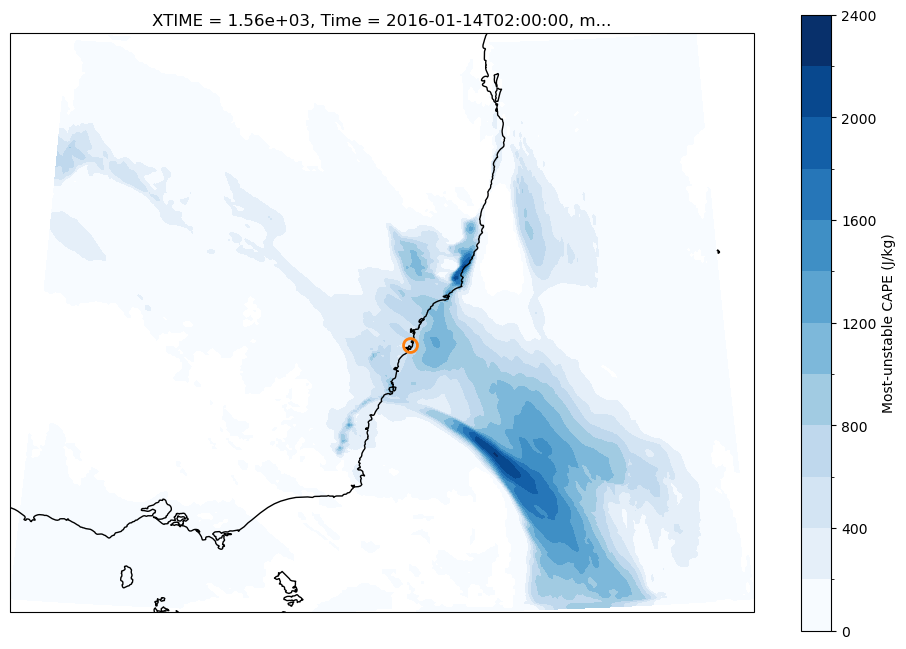

In [6]:
plt.figure(figsize=[12,8])
ax=plt.axes(projection=ccrs.PlateCarree())
c=xr.plot.contourf(cape,x="XLONG",y="XLAT",ax=ax,levels=15,cmap=plt.get_cmap("Blues"),add_colorbar=False)
cb=plt.colorbar(c)
cb.set_label("Most-unstable CAPE (J/kg)")
ax.coastlines()
ax.plot(wrf_lon,wrf_lat,marker="o",color="tab:orange",ms=10,mew=2,mfc="none")

plt.savefig("/home/548/ab4502/working/wrf_output_analysis/20160114_map.jpeg",dpi=400)